
# Cancer detection through the multi-analyte blood test CancerSEEK


The only widely used blood test for earlier cancer detection is based on measurement of prostate-specific antigen, and the proper use of this test is still being [debated](https://www.nejm.org/doi/full/10.1056/NEJMsb1616281). The approved tests for cancer detection are not blood-based and include colonoscopy, mammography, and cervical cytology. New blood tests for cancer must have very high specificity; otherwise, too many healthy individuals will receive positive test results, leading to unnecessary follow-up procedures and anxiety.

Earlier detection is key to reducing cancer deaths. CancerSEEK is a new type of blood test being tested out with the aim of improving cancer detection. It can detect eight common cancer types through the assessment of the levels of circulating proteins and mutations in cell-free DNA. The test was applied on 1005 patients with nonmetastatic, clinically detected cancers of ovary, liver, stomach, pancreas, esophagus, colorectum, lung or breast. __The median sensitivity was 0.70 for the eight cancer types.__ The top sensitivities ranged from 0.69 to 0.98 for the detection of five cancer types (ovary, liver, stomach, pancreas, and esophagus). Additionally, 812 healthy control patients were included in the study. 


The complete dataset can be found through [this](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6080308/#SD2) link, which is related to [this](https://science.sciencemag.org/content/359/6378/926.long) research paper. The research team has already worked on the dataset through a PCA-based sequencing of each sample to detect low-prevelance mutations and proteins. 

Earlier research has been done on this very same dataset, nevertheless, let's see if we can improve the results! Both in terms of Sensitivity and Specificity. **The project will focus on maximising Sensitivity as I consider it being more important to find as many of the patients with cancer as possible rather than incorrectly classifying healthy patients as sick.** The former might lead to a patient's death, while the latter "only" puts them through more tests. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from joblib import dump, load

from sklearn import tree, ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score, precision_recall_curve
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, GridSearchCV

import scipy
from scipy.stats import boxcox, jarque_bera, normaltest

%matplotlib inline
sns.set(style="whitegrid")

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [3]:
# Load the dataset
data = pd.read_excel('NIHMS982921-supplement-Tables_S1_to_S11.xlsx', skiprows=2, 
                     sheet_name=['TABLE S4', 'TABLE S5', 'TABLE S6'])
table4, table5, table6 = data['TABLE S4'], data['TABLE S5'], data['TABLE S6']

## Data Exploration and Cleaning

In [4]:
print(table4.shape)
print("Unique patient IDs: {}".format(len(table4['Patient ID #'].unique())))
table4.head()

(1821, 13)
Unique patient IDs: 1821


,Patient ID #,Plasma sample ID #,Primary tumor sample ID #,Age,Sex,Race,Tumor type,AJCC Stage,Histopathology,Plasma volume (mL),Plasma DNA concentration (ng/mL),CancerSEEK Logistic Regression Score,CancerSEEK Test Result
0,CRC 455,CRC 455 PLS 1,Not available,59.811088,Male,Caucasian,Colorectum,I,Adenocarcinoma,5.0,6.079696,0.938342,Positive
1,CRC 456,CRC 456 PLS 1,CRC 456 PT1,59.091034,Female,Caucasian,Colorectum,I,Adenocarcinoma,4.0,46.005220,0.925363,Positive
2,CRC 457,CRC 457 PLS 1,CRC 457 PT1,68.618754,Female,Caucasian,Colorectum,II,Adenocarcinoma,4.5,6.940071,0.852367,Negative
3,CRC 458,CRC 458 PLS 1,CRC 458 PT1,69.563313,Female,Caucasian,Colorectum,II,Adenocarcinoma,7.5,7.149544,0.617639,Negative
4,CRC 459,CRC 459 PLS 1,CRC 459 PT1,43.359343,Female,Caucasian,Colorectum,II,Adenocarcinoma,5.0,9.814674,0.318434,Negative


In [5]:
table4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 13 columns):
Patient ID #                            1820 non-null object
Plasma sample ID #                      1817 non-null object
Primary tumor sample ID #               1817 non-null object
Age                                     1817 non-null float64
Sex                                     1817 non-null object
Race                                    1817 non-null object
Tumor type                              1817 non-null object
AJCC Stage                              1005 non-null object
Histopathology                          1005 non-null object
Plasma volume (mL)                      1817 non-null float64
Plasma DNA concentration (ng/mL)        1817 non-null float64
CancerSEEK Logistic Regression Score    1817 non-null float64
CancerSEEK Test Result                  1817 non-null object
dtypes: float64(4), object(9)
memory usage: 185.0+ KB


In [6]:
print(table5.shape)
print("Unique patient IDs: {}".format(len(table5['Patient ID #'].unique())))
table5.head()

(1819, 12)
Unique patient IDs: 1819


,Patient ID #,Sample ID #,Tumor type,AJCC Stage,Plasma volume (mL),Plasma DNA concentration (ng/mL),Mutation identified in plasma*,Ω score,Mutant allele frequency (%),Mutant fragments/mL plasma,CancerSEEK Logistic Regression Score,CancerSEEK Test Result
0,CRC 455,CRC 455 PLS 1,Colorectum,I,5.0,6.079696,"TP53 p.K120E, c.358A>G",2.962820,0.272183,5.096751,0.938342,Positive
1,CRC 456,CRC 456 PLS 1,Colorectum,I,4.0,46.005220,"TP53 p.S240I, c.719G>T",2.445405,0.022625,3.205890,0.925363,Positive
2,CRC 457,CRC 457 PLS 1,Colorectum,II,4.5,6.940071,"TP53 p.R202C, c.604C>T",1.215758,0.063458,1.356452,0.852367,Negative
3,CRC 458,CRC 458 PLS 1,Colorectum,II,7.5,7.149544,"TP53 p.R248Q, c.743G>A",1.640793,0.164990,3.633174,0.617639,Negative
4,CRC 459,CRC 459 PLS 1,Colorectum,II,5.0,9.814674,"TP53 p.A276G, c.827C>G",1.325771,0.083155,2.513702,0.318434,Negative


In [7]:
table5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1819 entries, 0 to 1818
Data columns (total 12 columns):
Patient ID #                            1818 non-null object
Sample ID #                             1817 non-null object
Tumor type                              1817 non-null object
AJCC Stage                              1005 non-null object
Plasma volume (mL)                      1817 non-null float64
Plasma DNA concentration (ng/mL)        1817 non-null float64
Mutation identified in plasma*          1817 non-null object
Ω score                                 1751 non-null float64
Mutant allele frequency (%)             1751 non-null float64
 Mutant fragments/mL plasma             1751 non-null float64
CancerSEEK Logistic Regression Score    1817 non-null float64
CancerSEEK Test Result                  1817 non-null object
dtypes: float64(6), object(6)
memory usage: 170.6+ KB


In [8]:
print(table6.shape)
print("Unique patient IDs: {}".format(len(table6['Patient ID #'].unique())))
table6.tail()

(1821, 45)
Unique patient IDs: 1192


,Patient ID #,Sample ID #,Tumor type,AJCC Stage,AFP (pg/ml),Angiopoietin-2 (pg/ml),AXL (pg/ml),CA-125 (U/ml),CA 15-3 (U/ml),CA19-9 (U/ml),CD44 (ng/ml),CEA (pg/ml),CYFRA 21-1 (pg/ml),DKK1 (ng/ml),Endoglin (pg/ml),FGF2 (pg/ml),Follistatin (pg/ml),Galectin-3 (ng/ml),G-CSF (pg/ml),GDF15 (ng/ml),HE4 (pg/ml),HGF (pg/ml),IL-6 (pg/ml),IL-8 (pg/ml),Kallikrein-6 (pg/ml),Leptin (pg/ml),Mesothelin (ng/ml),Midkine (pg/ml),Myeloperoxidase (ng/ml),NSE (ng/ml),OPG (ng/ml),OPN (pg/ml),PAR (pg/ml),Prolactin (pg/ml),sEGFR (pg/ml),sFas (pg/ml),SHBG (nM),sHER2/sEGFR2/sErbB2 (pg/ml),sPECAM-1 (pg/ml),TGFa (pg/ml),Thrombospondin-2 (pg/ml),TIMP-1 (pg/ml),TIMP-2 (pg/ml),CancerSEEK Logistic Regression Score,CancerSEEK Test Result
1816,PAPA 1357,PAPA 1357 PLS 1,Ovary,III,*879.498,3546.43,1493.32,1428.31,**836.85,37.9,13.78,*443.01,3060.11,1.01,1750.98,208.62,715.32,12.84,*32.802,0.75,17932.1,224.69,11,24.71,25193,93442.6,59.06,597.81,15.1,19.31,0.62,103657,9827.49,111737,1245.17,*207.24,72.22,3967.55,4045.18,*16.89,12877.1,88464,47219.24,1.0,Positive
1817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1818,*Protein concentration below the limit of dete...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1819,**Protein concentration above the limit of det...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1820,NA: Not available,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
table6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 45 columns):
Patient ID #                            1820 non-null object
Sample ID #                             1817 non-null object
Tumor type                              1817 non-null object
AJCC Stage                              1005 non-null object
AFP (pg/ml)                             1817 non-null object
Angiopoietin-2 (pg/ml)                  1817 non-null object
AXL (pg/ml)                             1811 non-null float64
CA-125 (U/ml)                           1817 non-null object
CA 15-3 (U/ml)                          1817 non-null object
CA19-9 (U/ml)                           1817 non-null object
CD44 (ng/ml)                            1811 non-null object
CEA (pg/ml)                             1817 non-null object
CYFRA 21-1 (pg/ml)                      1817 non-null object
DKK1 (ng/ml)                            1817 non-null object
Endoglin (pg/ml)                      

We can see that table6 only has 1192 unique patient IDs compared with table5's 1819. The correct number of patient IDs should be 1817, according to the study referred to above where the data is collected from. As we can see from displaying the bottom 5 data points for each set, the last two rows in table5 are virtually only NaN values, we can safely remove those. Regarding table6, we can de the same with the bottom 4 rows. Regarding the other "missing" unique patient IDs in table6, we would have to dig a little deeper. 

In [10]:
# Display the maximum count of one unique patient ID
print(max(table6['Patient ID #'].value_counts()))

table6[table6['Patient ID #'] == 'NL'][:5]

630


,Patient ID #,Sample ID #,Tumor type,AJCC Stage,AFP (pg/ml),Angiopoietin-2 (pg/ml),AXL (pg/ml),CA-125 (U/ml),CA 15-3 (U/ml),CA19-9 (U/ml),CD44 (ng/ml),CEA (pg/ml),CYFRA 21-1 (pg/ml),DKK1 (ng/ml),Endoglin (pg/ml),FGF2 (pg/ml),Follistatin (pg/ml),Galectin-3 (ng/ml),G-CSF (pg/ml),GDF15 (ng/ml),HE4 (pg/ml),HGF (pg/ml),IL-6 (pg/ml),IL-8 (pg/ml),Kallikrein-6 (pg/ml),Leptin (pg/ml),Mesothelin (ng/ml),Midkine (pg/ml),Myeloperoxidase (ng/ml),NSE (ng/ml),OPG (ng/ml),OPN (pg/ml),PAR (pg/ml),Prolactin (pg/ml),sEGFR (pg/ml),sFas (pg/ml),SHBG (nM),sHER2/sEGFR2/sErbB2 (pg/ml),sPECAM-1 (pg/ml),TGFa (pg/ml),Thrombospondin-2 (pg/ml),TIMP-1 (pg/ml),TIMP-2 (pg/ml),CancerSEEK Logistic Regression Score,CancerSEEK Test Result
1073,NL,NL PLS 918,Normal,NaN,*758.844,3001.22,7204.71,*4.902,36.52,*15.744,51.7,1693.69,*1895.694,0.88,1717.8,105.8,562.54,3.14,*124.53,0.18,*11825.82,164.52,*96.804,*7.974,8829.03,119236,37.49,358.71,2.36,8.75,0.21,42815.4,5968.36,20791.5,5341.22,*200.226,20.08,11166,7934.40,*16.416,3235.02,57082.9,47393.44,0.072789,Negative
1074,NL,NL PLS 919,Normal,NaN,867.44,2604.27,6107.10,*4.902,36.17,*15.744,30.99,1587.54,2904.45,0.78,1468.98,181.6,213.92,2.64,*124.53,0.12,*11825.82,201.47,*96.804,*7.974,4691.7,9510.21,20.13,241.33,1.85,7.75,0.18,79312.1,3492.17,38229.3,2415.87,*200.226,51.67,9875.21,4945.36,*16.416,*851.95,46370.7,46216.70,0.781365,Negative
1075,NL,NL PLS 920,Normal,NaN,*841.524,1828.03,9739.63,*5.01,9.03,*16.764,19.26,1362.41,*1972.89,0.6,2330.16,112.47,*223.35,2.78,*31.08,0.27,*4065.312,*167.01,5.91,*8.31,8009.91,43026.4,16.46,412.82,21.66,1.85,0.24,58774.8,4976.01,13377.6,3858.3,210.3,64.62,8769.32,5107.82,*16.698,*516.7,63114.7,49047.05,0.109049,Negative
1076,NL,NL PLS 921,Normal,NaN,*841.524,1511.74,4974.10,*5.01,21.19,*16.764,37.45,1244.08,*1972.89,0.61,1664.24,112.47,*223.35,2.58,*31.08,0.12,*4065.312,*167.01,*2.976,*8.31,7006.94,7106.51,33.15,321.89,*1.5,3.11,0.24,46884.5,2256.59,19061.1,1657.91,*194.202,42.52,9279.18,6627.07,*16.698,*516.7,50221.3,64847.68,0.064408,Negative
1077,NL,NL PLS 922,Normal,NaN,*841.524,1847.75,1295.64,*5.01,6.91,*16.764,28.59,2132.38,*1972.89,0.63,1977.85,98.38,*223.35,2.31,*31.08,0.2,*4065.312,*167.01,*2.976,*8.31,5963.93,18136.8,16.6,302.24,*1.5,3.69,0.22,62667.2,3570,14324.3,2820.52,*194.202,157.73,8854.19,5305.24,*16.698,*516.7,46993.2,53631.10,0.165175,Negative


As we can see above, there are 630 duplicates of the patient ID "NL" in table6. This must be some kind of error. Let's see how those same indeces are in table5:

In [11]:
table5.iloc[1073:1078, :]

,Patient ID #,Sample ID #,Tumor type,AJCC Stage,Plasma volume (mL),Plasma DNA concentration (ng/mL),Mutation identified in plasma*,Ω score,Mutant allele frequency (%),Mutant fragments/mL plasma,CancerSEEK Logistic Regression Score,CancerSEEK Test Result
1073,NL 918,NL PLS 918,Normal,NaN,7.5,3.667176,TP53 g.7577018C>T (Splice Site),0.000000,0.028832,0.325658,0.072789,Negative
1074,NL 919,NL PLS 919,Normal,NaN,7.5,1.984209,"TP53 p.R248Q, c.743G>A",0.890999,0.074897,0.457723,0.781365,Negative
1075,NL 920,NL PLS 920,Normal,NaN,7.5,2.890854,"TP53 p.R333H, c.998G>A",0.892982,0.065937,0.587091,0.109049,Negative
1076,NL 921,NL PLS 921,Normal,NaN,7.5,0.881371,"TP53 p.V157I, c.469G>A",0.000000,0.085960,0.233349,0.064408,Negative
1077,NL 922,NL PLS 922,Normal,NaN,7.5,3.686237,"TP53 p.C242Y, c.725G>A",0.564175,0.030622,0.347666,0.165175,Negative


table5 does not display these errors. They are OK. So, if we use table5's patient ID column when combining the two datasets we should be able to work around this problem. All other values are equal above (comparing columns that exist in both sets) so the duplicates in table6 must be an error. 


In [12]:
# Remove NaN value rows from table4, table5 and table6. 
ind_remove4 = table4[table4['Age'].isnull()].index
if len(ind_remove4) > 0:
    table4.drop(ind_remove4, axis=0, inplace=True)

ind_remove5 = table5[table5['Sample ID #'].isnull()].index
if len(ind_remove5) > 0:
    table5.drop(ind_remove5, axis=0, inplace=True)

ind_remove6 = table6[table6['Sample ID #'].isnull()].index
if len(ind_remove6) > 0:
    table6.drop(ind_remove6, axis=0, inplace=True)

# Replace table6's patient ID column with table5's
table6.loc[:, 'Patient ID #'] = table5.loc[:, 'Patient ID #'].values

Check for number of unique patients in each dataset again

In [13]:
# Number of unique patient IDs
print("Unique patient IDs in table4: {}".format(len(table4['Patient ID #'].unique())))
print("Unique patient IDs in table5: {}".format(len(table5['Patient ID #'].unique())))
print("Unique patient IDs in table6: {}".format(len(table6['Patient ID #'].unique())))

# This is the amount of samples in each table. They should be equal.
print("\nUnique Sample IDs in table4: {}".format(len(table4['Plasma sample ID #'].unique())))
print("Unique Sample IDs in table5: {}".format(len(table5['Sample ID #'].unique())))
print("Unique Sample IDs in table5: {}".format(len(table6['Sample ID #'].unique())))

Unique patient IDs in table4: 1817
Unique patient IDs in table5: 1817
Unique patient IDs in table6: 1817

Unique Sample IDs in table4: 1817
Unique Sample IDs in table5: 1817
Unique Sample IDs in table5: 1817


Great success!!

#### Combine the datasets

Comparing table5 and table6 we see that there are several columns that are equal. Let's remove those in table6 so we don't end up with duplicates in the final dataset when combined with table5.

In [14]:
cols_to_use = list(table6.columns.difference(table5.columns))

# Add the Sample ID column so we can merge the datasets on this.
cols_to_use.insert(0, 'Sample ID #') 
print(cols_to_use)

['Sample ID #', 'AFP (pg/ml)', 'AXL (pg/ml)', 'Angiopoietin-2 (pg/ml)', 'CA 15-3 (U/ml)', 'CA-125 (U/ml)', 'CA19-9 (U/ml)', 'CD44 (ng/ml)', 'CEA (pg/ml)', 'CYFRA 21-1 (pg/ml)', 'DKK1 (ng/ml)', 'Endoglin (pg/ml)', 'FGF2 (pg/ml)', 'Follistatin (pg/ml)', 'G-CSF (pg/ml)', 'GDF15 (ng/ml)', 'Galectin-3 (ng/ml)', 'HE4 (pg/ml)', 'HGF (pg/ml)', 'IL-6 (pg/ml)', 'IL-8 (pg/ml)', 'Kallikrein-6 (pg/ml)', 'Leptin (pg/ml)', 'Mesothelin (ng/ml)', 'Midkine (pg/ml)', 'Myeloperoxidase (ng/ml)', 'NSE (ng/ml)', 'OPG (ng/ml)', 'OPN (pg/ml)', 'PAR (pg/ml)', 'Prolactin (pg/ml)', 'SHBG (nM)', 'TGFa (pg/ml)', 'TIMP-1 (pg/ml)', 'TIMP-2 (pg/ml)', 'Thrombospondin-2 (pg/ml)', 'sEGFR (pg/ml)', 'sFas (pg/ml)', 'sHER2/sEGFR2/sErbB2 (pg/ml)', 'sPECAM-1 (pg/ml)']


Merge the three datasets on the "*Sample ID #*" column. Keep only *Age*, *Sex* and *Race* from table4.

In [15]:
# First, change column name on table4 from "Plasma sample ID #" to "Sample ID #".
table4.rename(columns={'Plasma sample ID #': 'Sample ID #'}, inplace=True)

# Merge datasets
full_data = pd.merge(table5, table6[cols_to_use], how='inner', on='Sample ID #')
full_data = pd.merge(full_data, table4[["Sample ID #", "Age", "Sex", "Race"]], how='inner', on='Sample ID #')
print(full_data.shape)
full_data.head()

(1817, 54)


,Patient ID #,Sample ID #,Tumor type,AJCC Stage,Plasma volume (mL),Plasma DNA concentration (ng/mL),Mutation identified in plasma*,Ω score,Mutant allele frequency (%),Mutant fragments/mL plasma,CancerSEEK Logistic Regression Score,CancerSEEK Test Result,AFP (pg/ml),AXL (pg/ml),Angiopoietin-2 (pg/ml),CA 15-3 (U/ml),CA-125 (U/ml),CA19-9 (U/ml),CD44 (ng/ml),CEA (pg/ml),CYFRA 21-1 (pg/ml),DKK1 (ng/ml),Endoglin (pg/ml),FGF2 (pg/ml),Follistatin (pg/ml),G-CSF (pg/ml),GDF15 (ng/ml),Galectin-3 (ng/ml),HE4 (pg/ml),HGF (pg/ml),IL-6 (pg/ml),IL-8 (pg/ml),Kallikrein-6 (pg/ml),Leptin (pg/ml),Mesothelin (ng/ml),Midkine (pg/ml),Myeloperoxidase (ng/ml),NSE (ng/ml),OPG (ng/ml),OPN (pg/ml),PAR (pg/ml),Prolactin (pg/ml),SHBG (nM),TGFa (pg/ml),TIMP-1 (pg/ml),TIMP-2 (pg/ml),Thrombospondin-2 (pg/ml),sEGFR (pg/ml),sFas (pg/ml),sHER2/sEGFR2/sErbB2 (pg/ml),sPECAM-1 (pg/ml),Age,Sex,Race
0,CRC 455,CRC 455 PLS 1,Colorectum,I,5.0,6.079696,"TP53 p.K120E, c.358A>G",2.962820,0.272183,5.096751,0.938342,Positive,1583.45,3621.04,5598.5,19.08,5.09,*16.452,9.81,540.07,*1938.654,0.78,2882.65,92.02,2144.33,*131.46,0.53,11.19,*3857.712,377.26,*11.316,*8.238,5938.28,75826.6,14.29,315.23,14.22,12.04,0.47,56516.6,8852.96,11606.6,55.06,*16.086,56428.7,39498.82,21863.7,3284.17,*204.792,6832.07,9368.53,59.811088,Male,Caucasian
1,CRC 456,CRC 456 PLS 1,Colorectum,I,4.0,46.005220,"TP53 p.S240I, c.719G>T",2.445405,0.022625,3.205890,0.925363,Positive,*715.308,2772.96,20936.3,10.04,7.27,40.91,27.57,5902.43,*1938.654,0.77,3921.77,164.06,1646.26,*131.46,2.39,9.9,5779.11,659.68,21.28,29.82,3409.18,211751,32.57,260.56,23.88,23.25,0.34,61001.4,20782.6,14375,72.92,*16.086,73940.5,41277.09,29669.7,1911.81,*204.792,5549.47,6224.55,59.091034,Female,Caucasian
2,CRC 457,CRC 457 PLS 1,Colorectum,II,4.5,6.940071,"TP53 p.R202C, c.604C>T",1.215758,0.063458,1.356452,0.852367,Negative,4365.53,4120.77,2350.93,16.96,*4.854,*16.452,14.59,973.75,1976.94,0.9,2410.16,154.77,2486.88,*131.46,0.5,11.61,*3857.712,329.07,*11.316,35.06,3338.6,2683.07,15.09,491.81,12.02,12.84,0.37,88896.2,7534.43,38375,173.78,179.03,22797.3,28440.60,6020.47,1743.94,*204.792,3698.16,4046.48,68.618754,Female,Caucasian
3,CRC 458,CRC 458 PLS 1,Colorectum,II,7.5,7.149544,"TP53 p.R248Q, c.743G>A",1.640793,0.164990,3.633174,0.617639,Negative,*715.308,2029.96,1604.34,8.31,5.39,*16.452,7.78,2027.53,*1938.654,0.64,1284.96,227.57,829.43,152.24,0.19,4.8,7819.17,266.66,15.3,15.89,3162.89,41859.8,16.52,230.45,6.49,22.79,*0.29,42549.6,4722.42,12072.5,29.47,*16.086,20441.2,25896.73,4331.02,1059.24,*204.792,5856,6121.93,69.563313,Female,Caucasian
4,CRC 459,CRC 459 PLS 1,Colorectum,II,5.0,9.814674,"TP53 p.A276G, c.827C>G",1.325771,0.083155,2.513702,0.318434,Negative,801.3,2069.17,2087.57,11.73,*4.854,*16.452,12.21,614.49,*1938.654,0.78,2552.72,134.72,2168.23,*131.46,0.3,8.92,*3857.712,370.88,*11.316,*8.238,4442.46,100119,8.81,238.47,13.33,27.2,*0.29,24274.1,6945.9,23718.2,78.07,*16.086,56288.5,49425.20,2311.91,1736.92,*204.792,5447.93,6982.32,43.359343,Female,Caucasian


The resulting dataset should contain the same amount of samples as before (1817). We can see that this is the case.

In [16]:
print("Amount of UNIQUE patient IDs: {}\n".format(len(full_data['Patient ID #'].unique())))

full_data.info()

Amount of UNIQUE patient IDs: 1817

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1817 entries, 0 to 1816
Data columns (total 54 columns):
Patient ID #                            1817 non-null object
Sample ID #                             1817 non-null object
Tumor type                              1817 non-null object
AJCC Stage                              1005 non-null object
Plasma volume (mL)                      1817 non-null float64
Plasma DNA concentration (ng/mL)        1817 non-null float64
Mutation identified in plasma*          1817 non-null object
Ω score                                 1751 non-null float64
Mutant allele frequency (%)             1751 non-null float64
 Mutant fragments/mL plasma             1751 non-null float64
CancerSEEK Logistic Regression Score    1817 non-null float64
CancerSEEK Test Result                  1817 non-null object
AFP (pg/ml)                             1817 non-null object
AXL (pg/ml)                             1811 non-null floa

### Data cleaning

We have various things to address, but let's start with: 

- change column _"Patient ID #"_ to ordinal numbers
- removing column _"Sample ID #"_ as we only need Patient ID to identify each patient. 
- change columns _"Tumor type"_, _"AJCC Stage"_ and _"CancerSEEK Test Result"_ to ordinal categorical
- removing the _*_ sign from corresponding columns


In [17]:
# Change column "Patient ID #" to ordinal numbers
full_data['Patient ID #'] = range(len(full_data['Patient ID #']))

In [18]:
# Remove column "Sample ID #" 
if 'Sample ID #' in full_data.columns:
    full_data.drop('Sample ID #', axis=1, inplace=True)

In [19]:
### Change column "Tumor type" to ordinal categorical ###
#full_data.loc[:, "Colorectum"] = pd.Categorical(full_data.loc[:, "Colorectum"]).codes # Another way to do it on
if 'Colorectum' in full_data['Tumor type'].unique():
    full_data.replace({'Tumor type': {'Colorectum': 1, 
                                      'Lung': 2,
                                      'Breast': 3,
                                      'Pancreas': 4,
                                      'Ovary': 5,
                                      'Esophagus': 6,
                                      'Liver': 7,
                                      'Stomach': 8,
                                      'Normal': 9}}, inplace=True)


### Change column "AJCC Stage" to ordinal categorical ###
if 'I' in full_data['AJCC Stage'].unique():
    full_data.replace({'AJCC Stage': {'I': 1, 
                                      'II': 2,
                                      'III': 3,
                                      'NaN': 0}}, inplace=True)

# Address the 'NaN' values in a different way. Above approach did not work.
indNaN = full_data.loc[:,'AJCC Stage'].loc[full_data['AJCC Stage'].isnull()].index
full_data.loc[indNaN,'AJCC Stage'] = 0
full_data.loc[:,'AJCC Stage'] = full_data.loc[:,'AJCC Stage'].astype(int)

### Change column "CancerSEEK Test Result" to ordinal categorical ###
if 'Positive' in full_data['CancerSEEK Test Result'].unique():
    full_data.replace({'CancerSEEK Test Result': {'Positive': 1, 
                                                  'Negative': 0}}, inplace=True)
    
### Change column "Sex" to ordinal categorical ###
if 'Female' in full_data['Sex'].unique():
    full_data.replace({'Sex': {'Male': 1, 
                               'Female': 2}}, inplace=True)
    
### Change column "Race" to ordinal categorical ###
if 'Caucasian' in full_data['Race'].unique():
    full_data.replace({'Race': {'Caucasian': 1, 
                                'Black': 2,
                                'Unknown': 3,
                                'Asian': 4,
                                'Hispanic': 5,
                                'Black/Hispanic': 6,
                                'Caucasian/Hispanic': 7,
                                'Other': 8}}, inplace=True)
    

### Change column "Age" to ordinal categorical ###
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
full_data.loc[:, "Age"] = pd.cut(full_data.loc[:, "Age"], bins)
full_data.loc[:, "Age"] = pd.Categorical(full_data.loc[:, "Age"]).codes

In [20]:
# Strip "*" from each column
str_columns = full_data.select_dtypes(include=['object']).columns
for col in str_columns:
    full_data.loc[:, col] = full_data.loc[:, col].apply(lambda x: str(x).strip('*'))

    # Convert those same columns to float values. Except the "Mutation identified in plasma*" column!
    # It doesn't contain any numbers.
    if "Mutation identified in plasma*" not in col:
        full_data.loc[:, col] = full_data.loc[:, col].astype(float)

Below print out displays the type for each column. It seems that we've been successful in converting them adequately. 

In [21]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1817 entries, 0 to 1816
Data columns (total 53 columns):
Patient ID #                            1817 non-null int64
Tumor type                              1817 non-null int64
AJCC Stage                              1817 non-null int64
Plasma volume (mL)                      1817 non-null float64
Plasma DNA concentration (ng/mL)        1817 non-null float64
Mutation identified in plasma*          1817 non-null object
Ω score                                 1751 non-null float64
Mutant allele frequency (%)             1751 non-null float64
 Mutant fragments/mL plasma             1751 non-null float64
CancerSEEK Logistic Regression Score    1817 non-null float64
CancerSEEK Test Result                  1817 non-null int64
AFP (pg/ml)                             1817 non-null float64
AXL (pg/ml)                             1811 non-null float64
Angiopoietin-2 (pg/ml)                  1817 non-null float64
CA 15-3 (U/ml)                    

----

Taking a closer look at the _"Mutation identified in plasma*"_ column we can see that there are 604 unique mutations in our dataset. Creating dummy variables for all these variations will add an additional 604 features to our current 50, certainly leading to longer processing time. **Depending on our models' accuracy and sensitivity later on, this might be worth to explore further**, but as for now, let's remove the column from our dataset along with some other not useful ones. 

In [22]:
len(full_data['Mutation identified in plasma*'].unique())

604

In [23]:
# Remove two unwanted columns
cols_to_exclude = ["Patient ID #", "Mutation identified in plasma*"]
if "Patient ID #" in full_data.columns:
    for col in cols_to_exclude:
        full_data.drop(col, axis=1, inplace=True)
        
# Move our target variable "CancerSEEK Test Result" to the first position
if full_data.columns.tolist()[0] != 'CancerSEEK Test Result':
    cols = full_data.columns.tolist()
    cols = [cols[8]] + cols[:8] + cols[9:]
    full_data = full_data[cols]

### Address Missing Values

Since we don't have an abundance of data, it's preferrable to use as much of it as possible for our predictions. As seen below, the most missing data for any column is around 3.8%. Let's fill out these spots with some unharmful values; impute with the mean. 

In [24]:
full_data.isnull().sum()/full_data.count()*100

CancerSEEK Test Result                  0.000000
Tumor type                              0.000000
AJCC Stage                              0.000000
Plasma volume (mL)                      0.000000
Plasma DNA concentration (ng/mL)        0.000000
Ω score                                 3.769275
Mutant allele frequency (%)             3.769275
 Mutant fragments/mL plasma             3.769275
CancerSEEK Logistic Regression Score    0.000000
AFP (pg/ml)                             0.000000
AXL (pg/ml)                             0.331309
Angiopoietin-2 (pg/ml)                  0.000000
CA 15-3 (U/ml)                          0.000000
CA-125 (U/ml)                           0.000000
CA19-9 (U/ml)                           0.000000
CD44 (ng/ml)                            0.331309
CEA (pg/ml)                             0.000000
CYFRA 21-1 (pg/ml)                      0.000000
DKK1 (ng/ml)                            0.000000
Endoglin (pg/ml)                        0.000000
FGF2 (pg/ml)        

In [25]:
# Impute missing values with the mean.
missing_values = full_data.columns[full_data.isna().any()].tolist()
for missCol in missing_values:
    full_data.loc[:, missCol].fillna(full_data.loc[:, missCol].mean(), inplace=True)

In [26]:
# Display the percentage of missing values for each column
full_data.isnull().sum()/full_data.count()*100

CancerSEEK Test Result                  0.0
Tumor type                              0.0
AJCC Stage                              0.0
Plasma volume (mL)                      0.0
Plasma DNA concentration (ng/mL)        0.0
Ω score                                 0.0
Mutant allele frequency (%)             0.0
 Mutant fragments/mL plasma             0.0
CancerSEEK Logistic Regression Score    0.0
AFP (pg/ml)                             0.0
AXL (pg/ml)                             0.0
Angiopoietin-2 (pg/ml)                  0.0
CA 15-3 (U/ml)                          0.0
CA-125 (U/ml)                           0.0
CA19-9 (U/ml)                           0.0
CD44 (ng/ml)                            0.0
CEA (pg/ml)                             0.0
CYFRA 21-1 (pg/ml)                      0.0
DKK1 (ng/ml)                            0.0
Endoglin (pg/ml)                        0.0
FGF2 (pg/ml)                            0.0
Follistatin (pg/ml)                     0.0
G-CSF (pg/ml)                   

## Data Visualisation and Transformation

Plot first the raw, untransformed, data. 

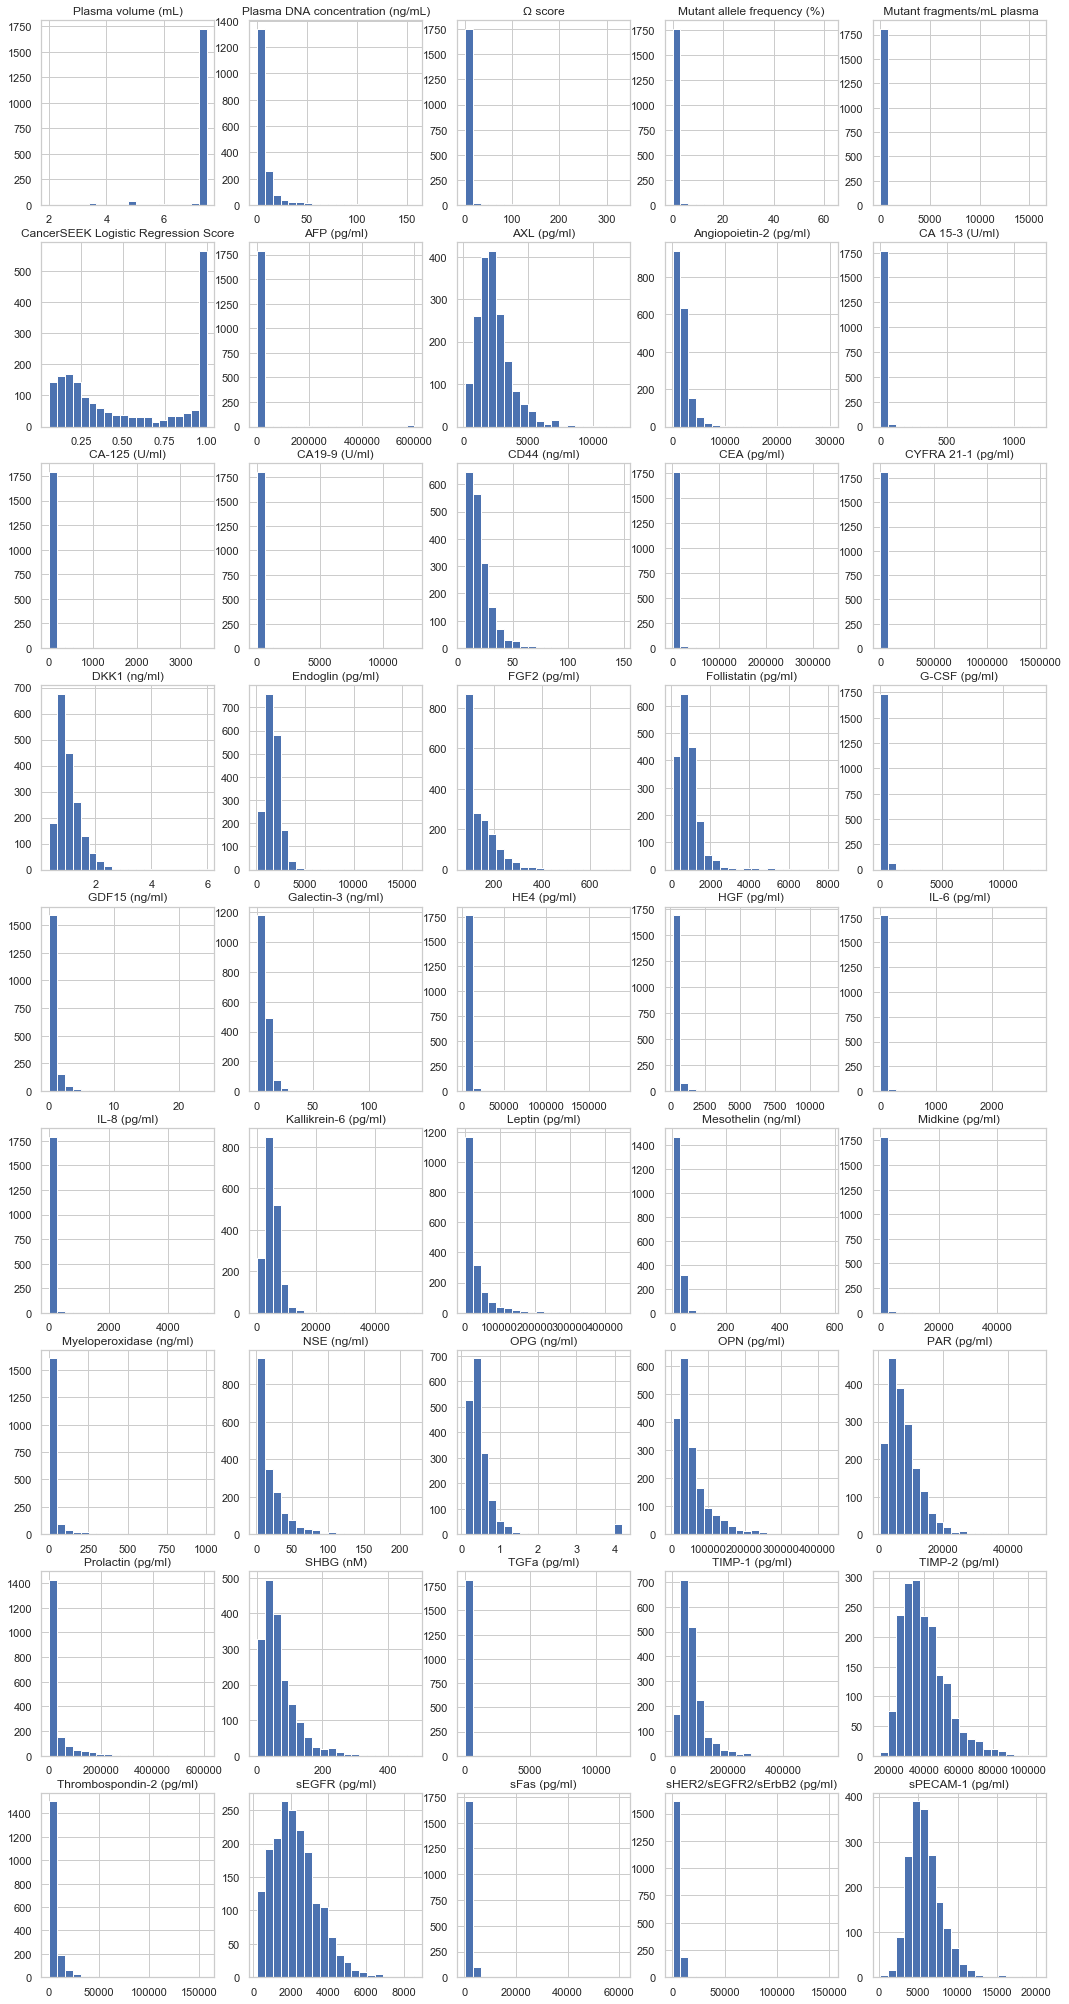

In [27]:
plt.figure(figsize=(18,36))

# Plot histograms of the cleaned data
for count, column in enumerate(full_data.select_dtypes(include=['float']).columns, 1):
    plt.subplot(9, 5, count)
    plt.hist(full_data.loc[:, column], bins=20)
    plt.title(column)

None of the features seems to display a normal distribution. Although drawing such a conclusion merely by visulising the data isn't good practice, the majority of the features are not even close to being normally distributed. Let's transform them while still keeping the raw ones. 

#### BoxCox transform the data

We can only do this to data that's larger than zero. Also, it doesn't make any sense to do it on categorical data. We can thus boxcox transform the same data as plotted above, except for the _"Ω score"_, which contain 80 nulls. 

In [31]:
full_data['Ω score'][full_data['Ω score'] == 0].count()

80

In [32]:
# Create a copy of the full_data dataframe for the BoxCox transformed data
transformed_data = full_data.copy(deep=True)

In [33]:
#transformed_data.select_dtypes(include=['float'])

In [34]:
# Select columns for BoxCox transformation
boxcox_columns = list(transformed_data.select_dtypes(include=['float']).columns[1:])
boxcox_columns.remove('Ω score')

In [35]:
#boxcox_data[boxcox_columns][boxcox_data[boxcox_columns] >= 0].any()

In [39]:
not_transformed = []
for column in boxcox_columns:
    warnings.filterwarnings('error')
    try:
        # BoxCox transform column
        boxcoxED = boxcox(transformed_data[column])[0]
        
    except RuntimeWarning:
        # Store error columns here
        not_transformed.append(column)
    
    # Add the BoxCox transformed data to the dataframe
    transformed_data[str(column+"__BoxCox")] = boxcoxED

print("Following columns were not transformed: \n{}".format(not_transformed))

Following columns were not transformed: 
['AFP (pg/ml)', 'CEA (pg/ml)', 'CYFRA 21-1 (pg/ml)', 'HE4 (pg/ml)', 'HGF (pg/ml)', 'Leptin (pg/ml)', 'Prolactin (pg/ml)', 'TIMP-2 (pg/ml)', 'Thrombospondin-2 (pg/ml)', 'sFas (pg/ml)', 'sHER2/sEGFR2/sErbB2 (pg/ml)']


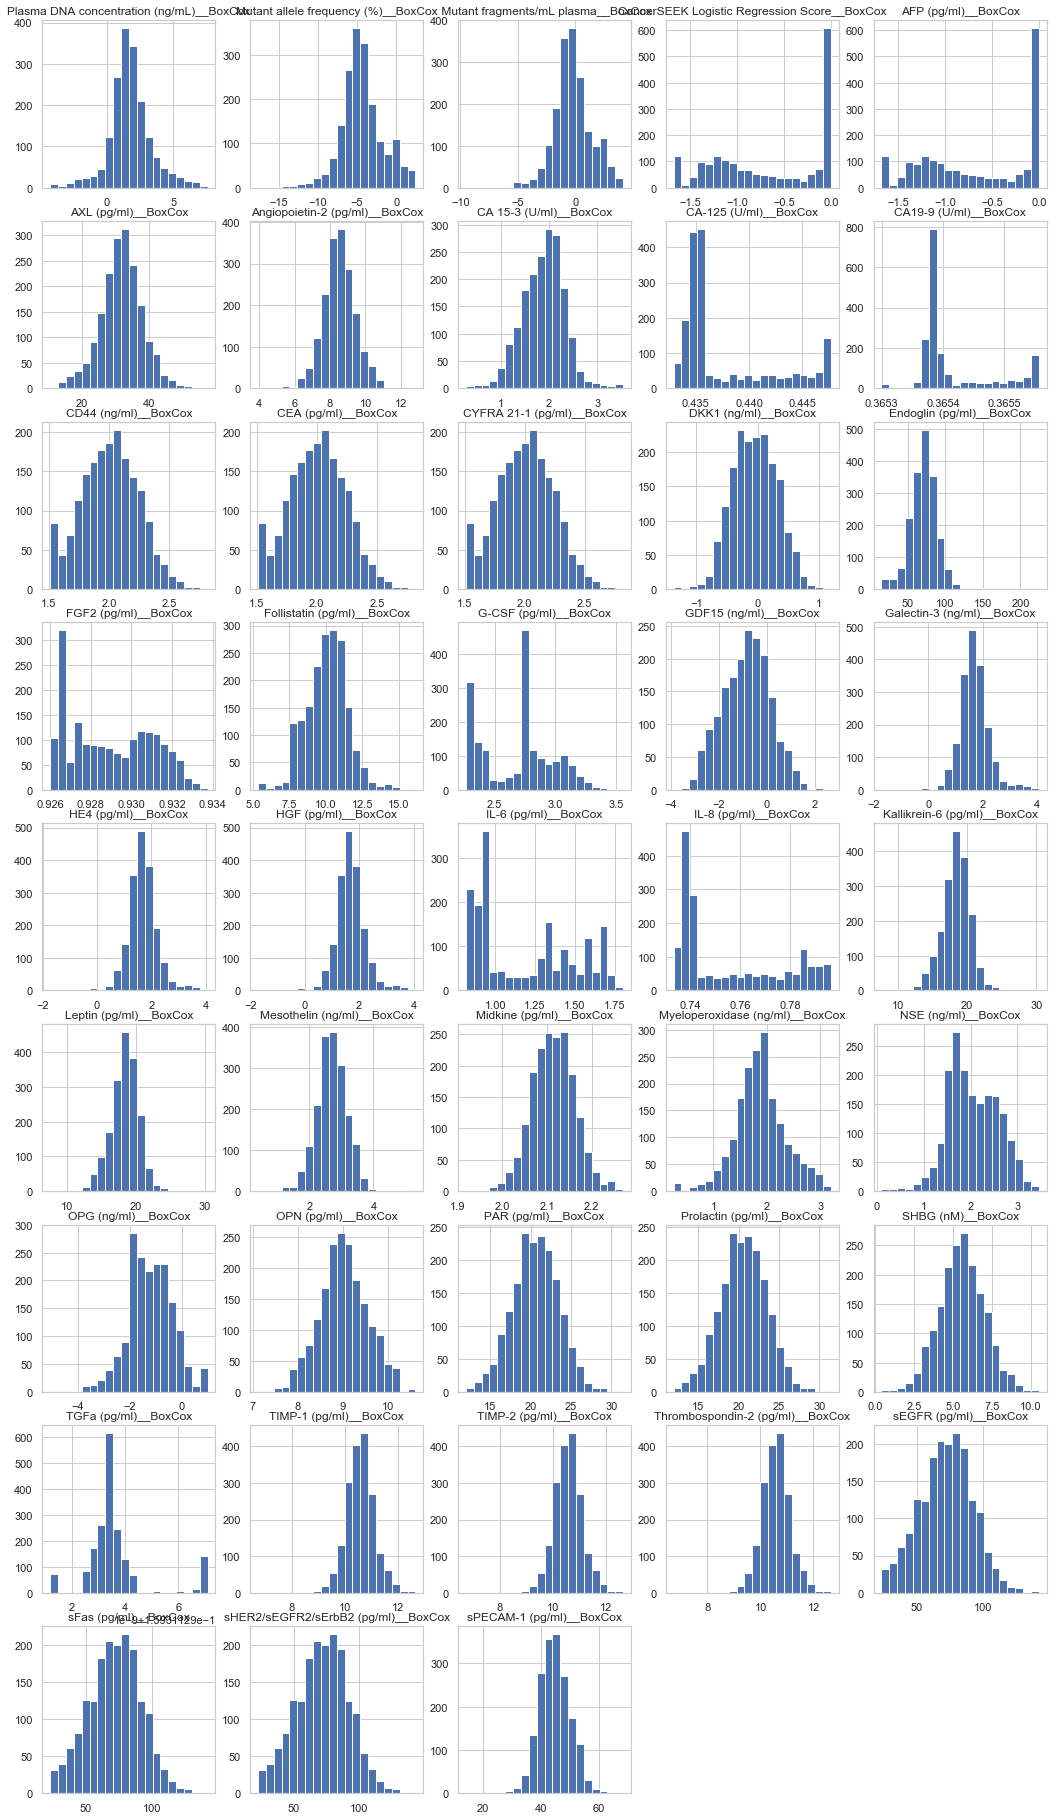

In [41]:
plt.figure(figsize=(18,40))

# Plot histograms of the transformed data
for count, column in enumerate(transformed_data.iloc[:, 51:].columns, 1):
    plt.subplot(11, 5, count)
    plt.hist(transformed_data.loc[:, column], bins=20)
    plt.title(column)

Some of the columns resemble a normal distribution, while others don't. Let's do a t-test to confirm this. __The null hypothesis is that the sample comes from a normal distribution.__ Since we can't use a Jarque-Bera test, due to the low number of patients, let's go with a Normal test instead.

In [42]:
for col in transformed_data.iloc[:, 51:].columns:
    k2, p = normaltest(transformed_data.loc[:, col])
    
    print("\nTEST FOR: {}".format(col))
    print("Normality test statistics is {0} and p value is {1}".format(k2, p))


TEST FOR: Plasma DNA concentration (ng/mL)__BoxCox
Normality test statistics is 81.90621666488151 and p value is 1.637913771432433e-18

TEST FOR: Mutant allele frequency (%)__BoxCox
Normality test statistics is 42.77740935969566 and p value is 5.140478919325605e-10

TEST FOR:  Mutant fragments/mL plasma__BoxCox
Normality test statistics is 32.45211684342753 and p value is 8.976610150498112e-08

TEST FOR: CancerSEEK Logistic Regression Score__BoxCox
Normality test statistics is 9.283377983667119 and p value is 0.009641399622586942

TEST FOR: AFP (pg/ml)__BoxCox
Normality test statistics is 9.283377983667119 and p value is 0.009641399622586942

TEST FOR: AXL (pg/ml)__BoxCox
Normality test statistics is 25.398976334839972 and p value is 3.0526876232265615e-06

TEST FOR: Angiopoietin-2 (pg/ml)__BoxCox
Normality test statistics is 75.10391293462142 and p value is 4.913517662922949e-17

TEST FOR: CA 15-3 (U/ml)__BoxCox
Normality test statistics is 28.945482676232952 and p value is 5.1828459

We can see above that some features are normally distributed while most aren't. (We are looking for **small squared z-values** and **p-values larger than 0.05**.) Some normally distributed features are _"OPN (pg/ml)_BoxCox"_, _"PAR (pg/ml)_BoxCox"_ and _"Prolactin (pg/ml)__BoxCox"_. 


#### Log transformation
Let's address the features that weren't possible to transform using BoxCox with a Logarithmic transformation instead:

In [43]:
# Log transform remaining features
for column in not_transformed:
    # Log transform column
    logED = np.log(transformed_data[column])
    
    # Add the Log transformed data to the dataframe
    transformed_data[str(column+"__Log")] = logED

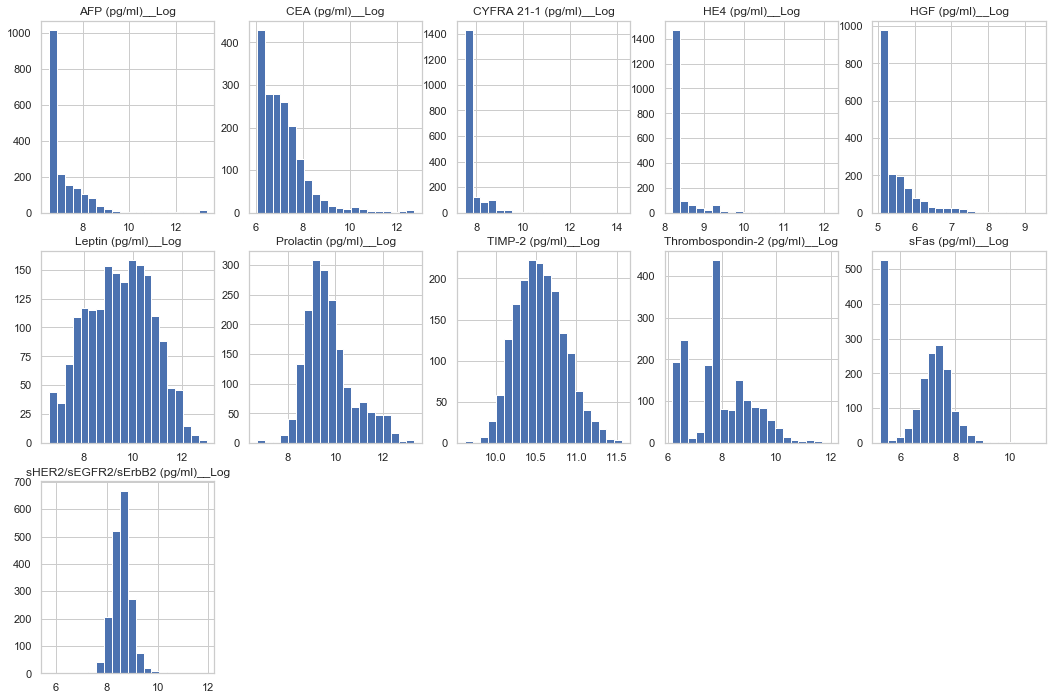

In [44]:
plt.figure(figsize=(18,12))

# Plot histograms of the Log transformed data
for count, column in enumerate(transformed_data.iloc[:, 94:].columns, 1):
    plt.subplot(3, 5, count)
    plt.hist(transformed_data.loc[:, column], bins=20)
    plt.title(column)

In [45]:
for col in transformed_data.iloc[:, 94:].columns:
    k2, p = normaltest(transformed_data.loc[:, col])
    
    print("\nTEST FOR: {}".format(col))
    print("Normality test statistics is {0} and p value is {1}".format(k2, p))


TEST FOR: AFP (pg/ml)__Log
Normality test statistics is 1347.4769697908625 and p value is 2.506650379729255e-293

TEST FOR: CEA (pg/ml)__Log
Normality test statistics is 792.0084262008186 and p value is 1.0412510204959293e-172

TEST FOR: CYFRA 21-1 (pg/ml)__Log
Normality test statistics is 1702.151037011804 and p value is 0.0

TEST FOR: HE4 (pg/ml)__Log
Normality test statistics is 1532.1117519681427 and p value is 0.0

TEST FOR: HGF (pg/ml)__Log
Normality test statistics is 795.1131427543942 and p value is 2.204828461804948e-173

TEST FOR: Leptin (pg/ml)__Log
Normality test statistics is 112.22171794898533 and p value is 4.279209731440676e-25

TEST FOR: Prolactin (pg/ml)__Log
Normality test statistics is 172.24755042590382 and p value is 3.952934920348992e-38

TEST FOR: TIMP-2 (pg/ml)__Log
Normality test statistics is 29.836666068360795 and p value is 3.3193288762219665e-07

TEST FOR: Thrombospondin-2 (pg/ml)__Log
Normality test statistics is 64.03761036068548 and p value is 1.242823

Log transforming the remaining features haven't really done more than visually moving some features closer to a normal distribution. The normal test rejects that they are normally distributed. 

### Features Selection

Select the features with most explanatory power. 

In [46]:
# Create correlation matrix. 
corr_mat = np.abs((transformed_data.corr().loc[:,"CancerSEEK Test Result"])).sort_values(ascending=False)
corr_mat[1:100]

CancerSEEK Logistic Regression Score            0.867426
CancerSEEK Logistic Regression Score__BoxCox    0.806685
AFP (pg/ml)__BoxCox                             0.806685
AJCC Stage                                      0.626450
OPN (pg/ml)__BoxCox                             0.559973
IL-8 (pg/ml)__BoxCox                            0.548768
OPN (pg/ml)                                     0.545893
Tumor type                                      0.517881
HGF (pg/ml)__Log                                0.517847
Prolactin (pg/ml)__Log                          0.492049
 Mutant fragments/mL plasma__BoxCox             0.472088
IL-6 (pg/ml)__BoxCox                            0.467245
GDF15 (ng/ml)__BoxCox                           0.461741
Plasma DNA concentration (ng/mL)__BoxCox        0.453453
Prolactin (pg/ml)                               0.431747
TIMP-1 (pg/ml)                                  0.402700
CA-125 (U/ml)__BoxCox                           0.389046
CEA (pg/ml)__Log               

In [47]:
#from matplotlib.colors import ListedColormap

## Another way to display the features
#my_cmap = ListedColormap(sns.light_palette((250, 100, 50), input="husl", n_colors=50).as_hex())
#table = transformed_data.corr(method='pearson') 
#table.style.background_gradient(cmap=my_cmap, axis = 0)

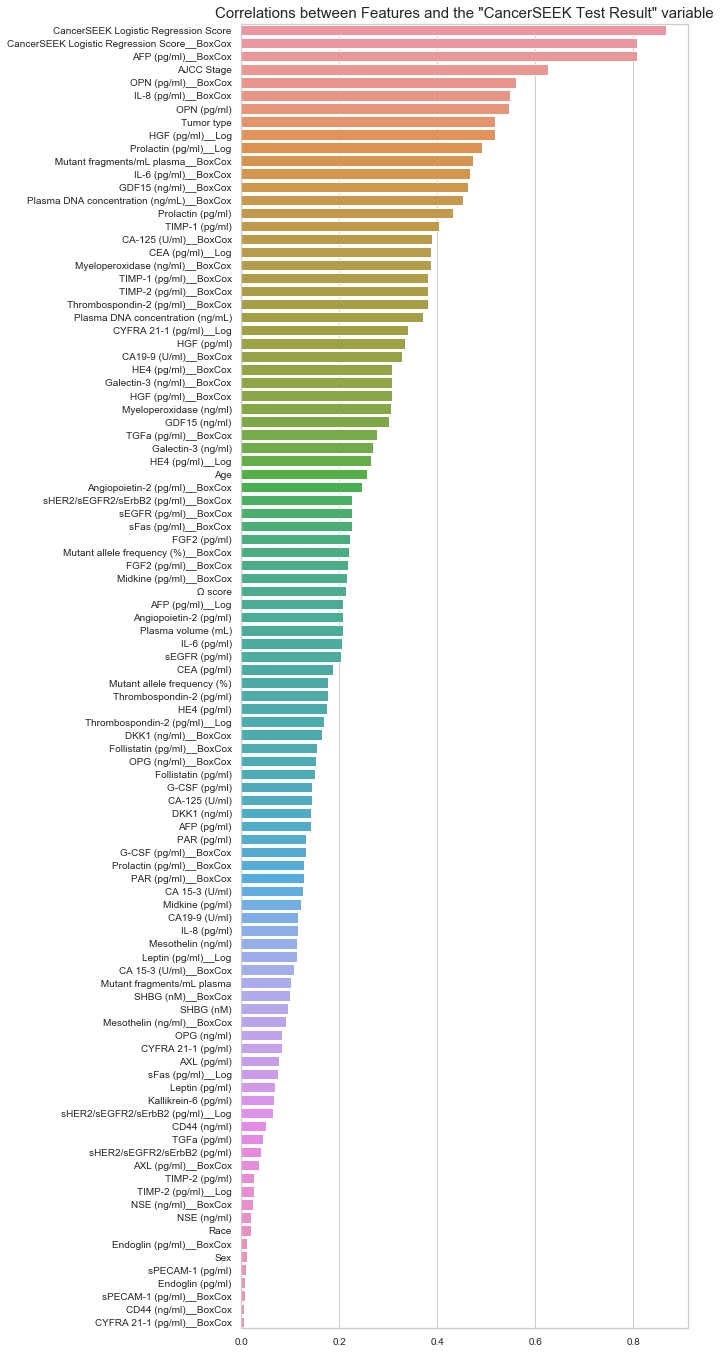

In [48]:
# Plot the correlation matrix for better understanding. Bar plot is used.
plt.figure(figsize=(8,24))

sns.barplot(y=corr_mat.index[1:101], x=corr_mat.iloc[1:101].values)
plt.title('Correlations between Features and the "CancerSEEK Test Result" variable', size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

In [49]:
# Define a function to extract the top number of features from a feature list.
def get_top_features(feature_list, nbr_features):
    """
        A function to extract the top nbr_features from a list of features, feature_list. 

        Note that the function will not return features that are their transformed equivalent;
        I.e. only the single feature with most variance among a BoxCox transformed and a raw 
        (Not transformed) feature will be returned.

        feature_list is assumed to be sorted with the feature with highest variance in the first position.
    """
    final_features = []
    for feature in feature_list:
        if feature.split('_')[0] not in str(final_features):
            final_features.append(feature)
            if len(final_features) == nbr_features:
                return final_features

In [50]:
# Get the top 25 features. Exclude our target variable as well as its corresponding Log score.
top_25_features = get_top_features(corr_mat.index.tolist()[3:], 25)
top_25_features

['AFP (pg/ml)__BoxCox',
 'AJCC Stage',
 'OPN (pg/ml)__BoxCox',
 'IL-8 (pg/ml)__BoxCox',
 'Tumor type',
 'HGF (pg/ml)__Log',
 'Prolactin (pg/ml)__Log',
 ' Mutant fragments/mL plasma__BoxCox',
 'IL-6 (pg/ml)__BoxCox',
 'GDF15 (ng/ml)__BoxCox',
 'Plasma DNA concentration (ng/mL)__BoxCox',
 'TIMP-1 (pg/ml)',
 'CA-125 (U/ml)__BoxCox',
 'CEA (pg/ml)__Log',
 'Myeloperoxidase (ng/ml)__BoxCox',
 'TIMP-2 (pg/ml)__BoxCox',
 'Thrombospondin-2 (pg/ml)__BoxCox',
 'CYFRA 21-1 (pg/ml)__Log',
 'CA19-9 (U/ml)__BoxCox',
 'HE4 (pg/ml)__BoxCox',
 'Galectin-3 (ng/ml)__BoxCox',
 'TGFa (pg/ml)__BoxCox',
 'Age',
 'Angiopoietin-2 (pg/ml)__BoxCox',
 'sHER2/sEGFR2/sErbB2 (pg/ml)__BoxCox']

Let's start by using the top 25 features for our model:

## Model Selection

Split the data into train and test sets and print some information about each set.

In [51]:
# Define predictors and outcome.
X = transformed_data[top_25_features]
Y = transformed_data["CancerSEEK Test Result"]

# Split into train and test sets. Use 20% for testing
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42)

In [52]:
# Print some statistics on the train and test sets
print("Number of rows in the train set:                               {}".format(len(trainY)))
print("Number of patients classified with cancer in the train set:    {}".format(len(trainY[trainY==1])))

print("\nNumber of rows in the test set:                                {}".format(len(testY)))
print("Number of patients classified with cancer in the test set:     {}".format(len(testY[testY==1])))

Number of rows in the train set:                               1453
Number of patients classified with cancer in the train set:    514

Number of rows in the test set:                                364
Number of patients classified with cancer in the test set:     119


### Decision Tree

First, try a basic decision tree classifier.

In [53]:
# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
                                            max_features='auto',
                                            max_depth=100,
                                            random_state=1337)
# Fit the model on the data
decision_tree.fit(trainX, trainY)

# Make predictions on both the train and test set
DT_predict_train = decision_tree.predict(trainX)
DT_predict_test = decision_tree.predict(testX)

In [54]:
def plot_Statistics(trainY, predicted_train, testY, predicted_test):
    """
       Function to plot Type I and Type II errors as well as 
       Sensitivity and Specificity for both the train and test set.
    """
    # Confusion Matrices
    confusion_matrix_train = pd.crosstab(trainY, predicted_train, rownames=['Actual'], 
                                            colnames=['Predicted'], margins=True)
    confusion_matrix_test = pd.crosstab(testY, predicted_test, rownames=['Actual'], 
                                           colnames=['Predicted'], margins=True)

    # Type I and II errors on train set
    train_tI_errors = confusion_matrix_train.loc[0.0,1.0] / confusion_matrix_train.loc['All','All']
    train_tII_errors = confusion_matrix_train.loc[1.0,0.0] / confusion_matrix_train.loc['All','All']

    # Type I and II errors on test set
    test_tI_errors = confusion_matrix_test.loc[0.0,1.0]/ confusion_matrix_test.loc['All','All']
    test_tII_errors = confusion_matrix_test.loc[1.0,0.0]/ confusion_matrix_test.loc['All','All']
    
    print(('Train set accuracy:\n'
       'Percent Type I errors: {}\n'
       'Percent Type II errors: {}\n\n'
       'Test set accuracy:\n'
       'Percent Type I errors: {}\n'
       'Percent Type II errors: {}\n'
       '\n------------------').format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))
    
    # Sensitivity and Specificity on the train set
    sensitivity_train = confusion_matrix_train.loc[1, 1] / confusion_matrix_train.loc[1, "All"]
    specificity_train = confusion_matrix_train.loc[0, 0] / confusion_matrix_train.loc[0, "All"]

    # Sensitivity and Specificity on the test set
    sensitivity_test = confusion_matrix_test.loc[1, 1] / confusion_matrix_test.loc[1, "All"]
    specificity_test = confusion_matrix_test.loc[0, 0] / confusion_matrix_test.loc[0, "All"]
    
    print("\nTrain set Sensitivity & Specificity:\n"
          "Sensitivity: {0}\n"
          "Specificity: {1}\n\n"
          "Test set Sensitivity & Specificity:\n"
          "Sensitivity: {2}\n"
          "Specificity: {3}".format(sensitivity_train, specificity_train, sensitivity_test, specificity_test))


def print_feature_importance(model, n=5):
    """Function to print the top n features model use to base its predictions on."""
    feature_importance = model.feature_importances_
    feature_df= pd.DataFrame({'features': X.columns,
                              'importance':feature_importance})
    feature_df.sort_values(by='importance', ascending=False, inplace=True)
    return feature_df.head(n)


def plot_confusion_matrix(testY, predicted, title, size=(3,3)):
    """Function to plot a Confusion Matrix."""
    plt.figure(figsize=size)
    conf_matrix = confusion_matrix(testY, predicted)
    
    ax = sns.heatmap(conf_matrix, annot=True, square=True, cbar=False)
    plt.title(title, size=16)
    plt.ylabel('Actual', size=14)
    plt.xlabel('Predicted', size=14)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.show()
    print(conf_matrix)


In [55]:
# Plot some statistics on the trained model
plot_Statistics(trainY, DT_predict_train, testY, DT_predict_test)

Train set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

Test set accuracy:
Percent Type I errors: 0.0027472527472527475
Percent Type II errors: 0.008241758241758242

------------------

Train set Sensitivity & Specificity:
Sensitivity: 1.0
Specificity: 1.0

Test set Sensitivity & Specificity:
Sensitivity: 0.9747899159663865
Specificity: 0.9959183673469387


Our basic decision tree classifier has both very high sensitivity (97.5%) and specificity (99.6%) on the test set. Impressive!

In [56]:
# Predict probabilities
probsDT = decision_tree.predict_proba(testX)

# Keep probabilities for the positive outcome only
probsDT = probsDT[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(testY, probsDT)

# Calculate the F1 score
f1 = f1_score(testY, DT_predict_test)

#print("Precision: {}".format(precision))
#print("Recall:    {}".format(recall))
print("F1 Score:  {}".format(f1))

F1 Score:  0.983050847457627


In [57]:
# Cross validate the model with 10 folds on average precision.
crossV_score = cross_val_score(decision_tree, X, Y, cv=10, scoring="accuracy")
print("Mean Cross Validation Accuracy: {}".format(np.mean(crossV_score)))

Mean Cross Validation Accuracy: 0.9714277420191738


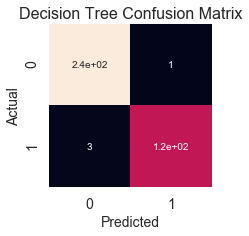

[[244   1]
 [  3 116]]


In [58]:
# Plot Confusion Matrix.
plot_confusion_matrix(testY, DT_predict_test, title="Decision Tree Confusion Matrix")

In [59]:
def plot_ROC_curve(testY, probs):
    """ Function for plotting a ROC curve, jointly with the Area Under the Curve Score (AUC Score)""" 

    fpr, tpr, threshold = roc_curve(testY, probs)
    auc = roc_auc_score(testY, probs)
    print('AUC',auc)

    plt.title('ROC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1.1])
    plt.ylim([0, 1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig('ROC')
    plt.show()

AUC 0.9853541416566627


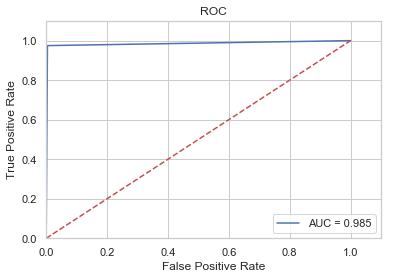

In [60]:
# Plot ROC Curve
plot_ROC_curve(testY, probsDT)

In [61]:
# Display what features were the most important for the model to make its predictions. 
print_feature_importance(decision_tree, n=5)

,features,importance
0,AFP (pg/ml)__BoxCox,0.673585
3,IL-8 (pg/ml)__BoxCox,0.244477
1,AJCC Stage,0.030392
8,IL-6 (pg/ml)__BoxCox,0.022031
4,Tumor type,0.020147


To conclude, the Decision Tree classifier performs very well on our test set, yielding:
- mean 10 cv score: 95,0%
- Sensitivity: 97,5%
- Specificty: 99,6%

### Random Forest

In [62]:
random_forest = ensemble.RandomForestClassifier(criterion='entropy',
                                                  n_estimators=100, 
                                                  max_depth=40, 
                                                  max_features='auto', 
                                                  bootstrap=True,
                                                  n_jobs=2)

random_forest.fit(trainX, trainY)

# Make predictions on both the train and test set
RF_predict_train = random_forest.predict(trainX)
RF_predict_test = random_forest.predict(testX)

In [63]:
# Plot some statistics on the trained model
plot_Statistics(trainY, RF_predict_train, testY, RF_predict_test)

Train set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

Test set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

------------------

Train set Sensitivity & Specificity:
Sensitivity: 1.0
Specificity: 1.0

Test set Sensitivity & Specificity:
Sensitivity: 1.0
Specificity: 1.0


In [64]:
# Predict probabilities
probsRF = random_forest.predict_proba(testX)

# Keep probabilities for the positive outcome only
probsRF = probsRF[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(testY, probsRF)

# Calculate the F1 score
f1 = f1_score(testY, RF_predict_test)

#print("Precision: {}".format(precision))
#print("Recall:    {}".format(recall))
print("F1 Score:  {}".format(f1))

F1 Score:  1.0


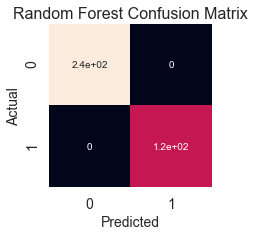

[[245   0]
 [  0 119]]


In [65]:
# Plot Confusion Matrix.
plot_confusion_matrix(testY, RF_predict_test, title="Random Forest Confusion Matrix")

AUC 1.0


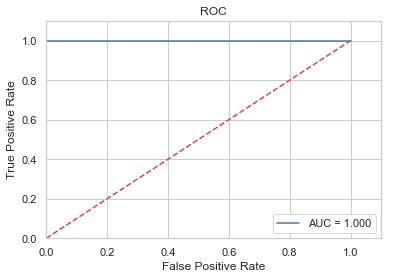

In [66]:
# Plot ROC Curve
plot_ROC_curve(testY, probsRF)

In [67]:
# Cross validate the model with 10 folds on average precision.
crossV_score = cross_val_score(random_forest, X, Y, cv=10, scoring="accuracy")

print("Mean Cross Validation Accuracy: {}".format(np.mean(crossV_score)))

Mean Cross Validation Accuracy: 0.9966850828729281


In [68]:
# Display what features were the most important for the model to make its predictions. 
print_feature_importance(random_forest, n=5)

,features,importance
0,AFP (pg/ml)__BoxCox,0.504275
1,AJCC Stage,0.096532
4,Tumor type,0.092605
3,IL-8 (pg/ml)__BoxCox,0.059065
6,Prolactin (pg/ml)__Log,0.051444


The Random Forest classifier:
- mean 10 cv score: 100%
- Sensitivity: 100%
- Specificty: 100%

The most important features for the model are *AFP (pg/ml)__BoxCox* (0.504), *AJCC Stage* (0.097) and *Tumor type* (0.093).

### Gradient Boosting

In [69]:
# We will use standard parameter settings
params = {'n_estimators': 100,
          'max_depth': 3,
          'loss': 'deviance',
          'subsample': 1}

# Initialize and fit the model.
grad_boost = ensemble.GradientBoostingClassifier(**params)
grad_boost.fit(trainX, trainY)

# Make predictions on both the train and test set
GB_predict_train = grad_boost.predict(trainX)
GB_predict_test = grad_boost.predict(testX)

In [70]:
# Plot some statistics on the trained model
plot_Statistics(trainY, GB_predict_train, testY, GB_predict_test)

Train set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

Test set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

------------------

Train set Sensitivity & Specificity:
Sensitivity: 1.0
Specificity: 1.0

Test set Sensitivity & Specificity:
Sensitivity: 1.0
Specificity: 1.0


In [71]:
# Predict probabilities
probsGB = grad_boost.predict_proba(testX)

# Keep probabilities for the positive outcome only
probsGB = probsGB[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(testY, probsGB)

# Calculate the F1 score
f1 = f1_score(testY, GB_predict_test)

#print("Precision: {}".format(precision))
#print("Recall:    {}".format(recall))
print("F1 Score:  {}".format(f1))

F1 Score:  1.0


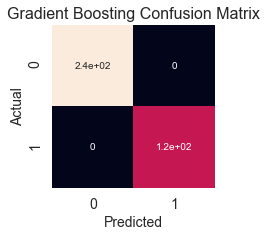

[[245   0]
 [  0 119]]


In [72]:
# Plot Confusion Matrix.
plot_confusion_matrix(testY, GB_predict_test, title="Gradient Boosting Confusion Matrix")

AUC 1.0


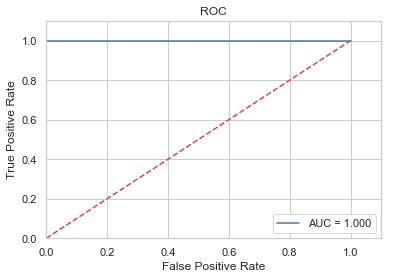

In [73]:
# Plot ROC Curve
plot_ROC_curve(testY, probsGB)

In [74]:
# Cross validate the model with 10 folds on average precision.
crossV_score = cross_val_score(grad_boost, X, Y, cv=10, scoring="accuracy")

print("Mean Cross Validation Accuracy: {}".format(np.mean(crossV_score)))

Mean Cross Validation Accuracy: 1.0


In [75]:
# Display what features were the most important for the model to make its predictions. 
print_feature_importance(grad_boost, n=5)

,features,importance
0,AFP (pg/ml)__BoxCox,1.0
13,CEA (pg/ml)__Log,0.0
23,Angiopoietin-2 (pg/ml)__BoxCox,0.0
22,Age,0.0
21,TGFa (pg/ml)__BoxCox,0.0


The Gradient Boosting classifier returns perfect scoring:
- mean 10 cv score: 100%
- Sensitivity: 100%
- Specificty: 100%

The most important feature for the model was the BoxCox transformed alpha-fetoprotein, *AFP (pg/ml)__BoxCox* (1.00), being the only feature having any importance in deciding the outcome of the predictions. 

It's slightly suspicious that merely one feature is able to predict the outcome on whether a test is positive or negative, but since the Random Forest classifier reached an equal perfect result by considering "only" 49% of the feature's predictive power, we can likely conclude that it is a valid input variable. I.e. it should not be treated as the target variable, and thus, not be excluded as an input feature. 


Nevertheless, let's see if we can score high with the Random Forest and Gradient Boosting model by excluding the *AFP (pg/ml)* feature, both transformed and non-transformed. Increase the number of features from 25 to 35 to compensate for this loss of variane. 

## Exclude the AFP (pg/ml) feature
#### (This will also indirectly show that our previous implementation has been correct)

In [2576]:
# Get the top 35 features. Exclude our target variable, corresponding Log score and the AFP (pg/ml) protein.
top_35_features = get_top_features(corr_mat.index.tolist()[3:], 36)
top_35_features = top_35_features[1:]
print(len(top_35_features))

35


In [2577]:
# Define predictors and outcome.
X = transformed_data[top_35_features]
Y = transformed_data["CancerSEEK Test Result"]

# Split into train and test sets. Use 20% for testing
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=2019)

In [2578]:
# Print some statistics on the train and test sets
print("Number of rows in the train set:                               {}".format(len(trainY)))
print("Number of patients classified with cancer in the train set:    {}".format(len(trainY[trainY==1])))

print("\nNumber of rows in the test set:                                {}".format(len(testY)))
print("Number of patients classified with cancer in the test set:     {}".format(len(testY[testY==1])))

Number of rows in the train set:                               1453
Number of patients classified with cancer in the train set:    517

Number of rows in the test set:                                364
Number of patients classified with cancer in the test set:     116


Perform a **Grid Search** to find the best parameter combination for both the Random Forest and Gradient Boosting algorithm. 


### Random Forest

In [2372]:
RF_35 = ensemble.RandomForestClassifier()
paramaters = {'n_estimators': [10, 50, 100, 150, 200, 400],
              'max_depth': [10, 50, 100, 150, 200],
              'min_samples_split':[2, 3, 4, 5],
              'criterion': ['entropy', 'gini']}

# Initiate the Random Forest Cross Validated Grid Search
clf = GridSearchCV(RF_35, paramaters, cv=5, iid='False',n_jobs=3, verbose=2)
clf.fit(trainX, trainY)

# Get the best estimator
RF_35_best = clf.best_estimator_
print(RF_35_best)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    8.8s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   37.7s
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed:  1.5min
[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed:  2.8min
[Parallel(n_jobs=3)]: Done 1007 tasks      | elapsed:  4.2min
[Parallel(n_jobs=3)]: Done 1200 out of 1200 | elapsed:  4.9min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [2579]:
# Make predictions on the train and test set
RF35_predict_train = RF_35_best.predict(trainX)
RF35_predict_test = RF_35_best.predict(testX)

In [2377]:
# Save best model to disk
filename = 'RF_35_model.joblib'
dump(RF_35_best, filename) 

# Load the model from disk
RF_35_loaded = load(filename)

In [2580]:
def plot_Sensitivity_Specificity(trainY, predicted_train, testY, predicted_test):
    """
       Function to print Sensitivity and Specificity on the test set.
    """
    # Confusion Matrix
    confusion_matrix_train = pd.crosstab(trainY, predicted_train, rownames=['Actual'], 
                                         colnames=['Predicted'], margins=True)
    confusion_matrix_test = pd.crosstab(testY, predicted_test, rownames=['Actual'], 
                                        colnames=['Predicted'], margins=True)   
    
    # Sensitivity and Specificity on the train set
    sensitivity_train = confusion_matrix_train.loc[1, 1] / confusion_matrix_train.loc[1, "All"]
    specificity_train = confusion_matrix_train.loc[0, 0] / confusion_matrix_train.loc[0, "All"]

    # Sensitivity and Specificity on the test set
    sensitivity_test = confusion_matrix_test.loc[1, 1] / confusion_matrix_test.loc[1, "All"]
    specificity_test = confusion_matrix_test.loc[0, 0] / confusion_matrix_test.loc[0, "All"]
    
    print("\nTrain set Sensitivity & Specificity:\n"
          "Sensitivity: {0}\n"
          "Specificity: {1}\n\n"
          "Test set Sensitivity & Specificity:\n"
          "Sensitivity: {2}\n"
          "Specificity: {3}".format(sensitivity_train, specificity_train, sensitivity_test, specificity_test))

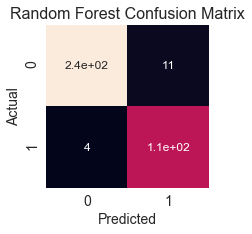

[[237  11]
 [  4 112]]


In [2581]:
# Plot Confusion Matrix.
plot_confusion_matrix(testY, RF35_predict_test, title="Random Forest Confusion Matrix")

In [2582]:
# Plot some statistics on the best performing model
plot_Sensitivity_Specificity(trainY, RF35_predict_train, testY, RF35_predict_test)


Train set Sensitivity & Specificity:
Sensitivity: 1.0
Specificity: 0.9989316239316239

Test set Sensitivity & Specificity:
Sensitivity: 0.9655172413793104
Specificity: 0.9556451612903226


In [2583]:
# Cross validate the model with 10 folds on average precision.
crossV_score = cross_val_score(RF_35_best, X, Y, cv=10, scoring="accuracy")
print("Mean Cross Validation Accuracy: {}".format(np.mean(crossV_score)))

Mean Cross Validation Accuracy: 0.918863141809433


### Gradient Boosting

In [2382]:
GB_35 = ensemble.GradientBoostingClassifier()
paramaters = {'n_estimators': [10, 50, 100, 150, 200],
              'learning_rate': [0.01, 0.1, 1.0],
              'max_depth': [2, 3, 4, 5],
              'min_samples_split': [2, 3, 4],
              'subsample': [1, 0.8, 0.6]}

# Initiate the Gradient Boosting Cross Validated Grid Search
clf = GridSearchCV(GB_35, paramaters, cv=5, iid='False',n_jobs=3, verbose=2)
clf.fit(trainX, trainY)

# Get the best estimator
GB_35_best = clf.best_estimator_
print(GB_35_best)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    7.4s
[Parallel(n_jobs=3)]: Done 184 tasks      | elapsed:   28.8s
[Parallel(n_jobs=3)]: Done 387 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 670 tasks      | elapsed:  2.1min
[Parallel(n_jobs=3)]: Done 1065 tasks      | elapsed:  3.4min
[Parallel(n_jobs=3)]: Done 1537 tasks      | elapsed:  4.7min
[Parallel(n_jobs=3)]: Done 2236 tasks      | elapsed:  6.6min
[Parallel(n_jobs=3)]: Done 2700 out of 2700 | elapsed:  7.5min finished


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=4,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.6, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [2584]:
# Make predictions on the train and test set
GB35_predict_train = GB_35_best.predict(trainX)
GB35_predict_test = GB_35_best.predict(testX)

In [2386]:
# Save best model to disk
filename = 'GB_35_model.joblib'
dump(GB_35_best, filename) 

# Load the model from disk
GB_35_loaded = load(filename) 

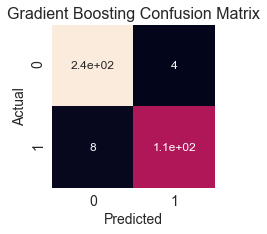

[[244   4]
 [  8 108]]


In [2585]:
# Plot Confusion Matrix.
plot_confusion_matrix(testY, GB35_predict_test, title="Gradient Boosting Confusion Matrix")

In [2586]:
# Plot some statistics on the best performing model
plot_Sensitivity_Specificity(trainY, GB35_predict_train, testY, GB35_predict_test)


Train set Sensitivity & Specificity:
Sensitivity: 1.0
Specificity: 1.0

Test set Sensitivity & Specificity:
Sensitivity: 0.9310344827586207
Specificity: 0.9838709677419355


In [2587]:
# Cross validate the model with 10 folds on average precision.
crossV_score = cross_val_score(GB_35_best, X, Y, cv=10, scoring="accuracy")
print("Mean Cross Validation Accuracy: {}".format(np.mean(crossV_score)))

Mean Cross Validation Accuracy: 0.9528062735199769


We still get very high results despite removing the AFP protein. 


# Predict Cancer Type

Now, try to predict which one of the eight **tumor types** each patient has. As this is a more complicated classification task with nine possible outcomes (eight tumor types + healthy) let us make use of the previous excluded AFP (pg/ml) feature. Also, choose all 48 features to increase prediction power. 

In [2588]:
# Create correlation matrix relative to "Tumor type". 
corr_mat_type = np.abs((transformed_data.corr().loc[:,"Tumor type"])).sort_values(ascending=False)

# Exclude "Tumor type"
corr_mat_type = corr_mat_type[1:]

# Exclude CancerSEEK regression scores and Test Result
cancer_type_features = [f for f in corr_mat_type.index.tolist() if "CancerSEEK" not in f]

# Get the top 45 features.
all_feat = get_top_features(cancer_type_features, 48)
len(all_feat)

48

In [2589]:
# Define predictors and outcome.
X = transformed_data[all_feat]
Y = transformed_data["Tumor type"]

# Split into train and test sets. Use 20% for testing
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42)

In [2590]:
trainX.head()

,AJCC Stage,AFP (pg/ml)__BoxCox,OPN (pg/ml)__BoxCox,Prolactin (pg/ml)__Log,IL-6 (pg/ml)__BoxCox,IL-8 (pg/ml)__BoxCox,GDF15 (ng/ml)__BoxCox,Age,CEA (pg/ml)__Log,Mutant fragments/mL plasma__BoxCox,Plasma DNA concentration (ng/mL)__BoxCox,HGF (pg/ml)__Log,sHER2/sEGFR2/sErbB2 (pg/ml)__BoxCox,sFas (pg/ml)__BoxCox,sEGFR (pg/ml)__BoxCox,CYFRA 21-1 (pg/ml)__Log,Midkine (pg/ml)__BoxCox,Myeloperoxidase (ng/ml)__BoxCox,CA-125 (U/ml)__BoxCox,Race,FGF2 (pg/ml)__BoxCox,TIMP-1 (pg/ml),HE4 (pg/ml)__Log,TIMP-2 (pg/ml)__BoxCox,Thrombospondin-2 (pg/ml)__BoxCox,SHBG (nM)__BoxCox,CA19-9 (U/ml)__BoxCox,Angiopoietin-2 (pg/ml)__BoxCox,Follistatin (pg/ml)__BoxCox,TGFa (pg/ml)__BoxCox,Mutant allele frequency (%)__BoxCox,Plasma volume (mL),Galectin-3 (ng/ml)__BoxCox,G-CSF (pg/ml),NSE (ng/ml)__BoxCox,Ω score,Sex,Mesothelin (ng/ml)__BoxCox,OPG (ng/ml),sPECAM-1 (pg/ml)__BoxCox,PAR (pg/ml),DKK1 (ng/ml)__BoxCox,AXL (pg/ml),CD44 (ng/ml),CA 15-3 (U/ml),Leptin (pg/ml),Endoglin (pg/ml),Kallikrein-6 (pg/ml)
292,2,-0.002197,9.674062,10.233986,1.678457,0.763150,-0.238944,8,7.969942,1.518893,2.120629,5.573180,74.375028,74.375028,74.375028,7.547340,2.141388,1.674816,0.437333,1,0.926493,54596.00,9.378041,10.506107,10.506107,4.804792,0.365433,9.947554,9.664558,0.159311,-1.338861,7.5,1.860463,124.530,1.482418,6.138448,1,3.400160,0.33,48.720521,11063.31,-0.131880,2032.99,29.98,9.26,8365.70,1529.11,7603.07
1417,0,-1.266084,9.121609,8.735528,0.952439,0.740301,-0.599569,7,6.530017,-0.679984,2.086632,5.099744,55.720623,55.720623,55.720623,7.618467,2.069817,1.682840,0.435280,1,0.927352,45748.50,8.317918,10.342063,10.342063,4.534379,0.365380,8.524565,11.446989,0.159311,-6.058962,7.5,1.939791,119.730,2.038912,0.986343,2,3.154305,0.84,40.311200,4461.72,0.368078,2421.42,13.44,15.33,40903.92,1701.05,4790.27
1548,0,-1.046947,8.871166,9.213502,0.923439,0.733523,-1.829761,5,7.229078,-0.865323,0.961370,5.106164,94.646147,94.646147,94.646147,7.598336,2.138618,0.927001,0.435380,3,0.926331,70733.02,8.305249,10.746012,10.746012,7.087862,0.365383,9.832864,9.802839,0.159311,-4.245089,7.5,1.167401,30.687,2.927771,0.816677,2,2.970883,0.29,50.817208,13852.66,0.246354,2332.53,13.03,8.29,6003.45,1138.48,3356.54
300,2,-0.000002,9.266404,9.889813,1.678457,0.787747,-0.320470,7,6.647585,2.488251,2.966252,5.605287,75.544568,75.544568,75.544568,8.421094,2.211716,1.419619,0.434835,1,0.930793,47793.33,9.378041,10.382653,10.382653,4.697238,0.365362,7.991299,9.664558,0.159311,-0.081212,7.5,1.198653,124.530,1.714298,10.561830,1,3.735038,0.51,47.507810,5406.35,-0.131880,2194.65,30.25,6.21,7047.89,1592.99,6838.43
1704,2,-0.644579,8.870977,10.422887,0.999717,0.772177,-1.709329,4,6.390123,-0.424350,1.305951,5.083588,80.902629,80.902629,80.902629,7.575041,2.107801,1.110325,0.441458,1,0.932384,43625.67,8.282157,10.297944,10.297944,8.339033,0.365509,8.077987,10.007770,0.159311,-4.042394,7.5,0.359280,49.250,2.566900,0.901357,2,3.114593,0.36,42.790386,8062.16,-0.718192,1036.63,14.02,4.87,14650.70,1075.47,5020.50


In [2591]:
def cancer_count():
    """Function to display the count for each cancer type in the dataset""" 
    cancers = ['Colorectum', 'Lung', 'Breast', 'Pancreas', 'Ovary', 
               'Esophagus', 'Liver', 'Stomach', 'Healthy', 'All']
    cancer_counts = pd.DataFrame(transformed_data.loc[:, "Tumor type"].value_counts()).sort_index(inplace=False).T
    cancer_counts.columns, cancer_counts.index = cancers[:-1], ["Cancer Count"]
    return cancer_counts

cancer_count()

,Colorectum,Lung,Breast,Pancreas,Ovary,Esophagus,Liver,Stomach,Healthy
Cancer Count,388,104,209,93,54,45,44,68,812


## Random Forest

In [2402]:
RF_Ctypes = ensemble.RandomForestClassifier()
paramaters = {'n_estimators': [100, 200, 400],
              'max_depth': [25, 50, 70, 85, 100],
              'min_samples_split':[2, 3, 4, 5, 6,],
              'criterion': ['entropy', 'gini']}

# Initiate the Random Forest Cross Validated Grid Search
clf = GridSearchCV(RF_Ctypes, paramaters, cv=5, iid='False',n_jobs=3, verbose=3)
clf.fit(trainX, trainY)

# Get the best estimator
RF_Ctypes_best = clf.best_estimator_
print(RF_Ctypes_best)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   28.4s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  2.2min
[Parallel(n_jobs=3)]: Done 282 tasks      | elapsed:  5.0min
[Parallel(n_jobs=3)]: Done 506 tasks      | elapsed:  9.5min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 13.0min
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed: 15.5min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [2592]:
# Make predictions on both the train and test set
RF_Ctypes_predict_train = RF_Ctypes_best.predict(trainX)
RF_Ctypes_predict_test = RF_Ctypes_best.predict(testX)

In [2544]:
# Save best model to disk
filename = 'RF_Ctypes_model.joblib'
dump(RF_Ctypes_best, filename) 

# Load the model from disk
RF_Ctypes_loaded = load(filename) 

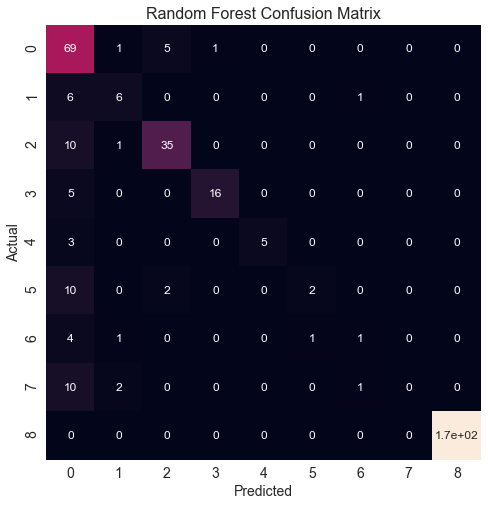

[[ 69   1   5   1   0   0   0   0   0]
 [  6   6   0   0   0   0   1   0   0]
 [ 10   1  35   0   0   0   0   0   0]
 [  5   0   0  16   0   0   0   0   0]
 [  3   0   0   0   5   0   0   0   0]
 [ 10   0   2   0   0   2   0   0   0]
 [  4   1   0   0   0   1   1   0   0]
 [ 10   2   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   0 166]]


In [2593]:
# Plot Confusion Matrix.
plot_confusion_matrix(testY, RF_Ctypes_predict_test, title="Random Forest Confusion Matrix", size=(8, 8))

In [2594]:
def cancer_type_stats(true, predicted):
    """Function to print Sensitivity and Specificity for each one 
       of the nine cancer types (healthy included). """
    
    # Create confusion matrix
    conf_matrix = pd.DataFrame(confusion_matrix(true, predicted))
    new_ind = conf_matrix.index.append(pd.Index(["All"]))

    # Add a summary column and index
    conf_matrix["All"] = conf_matrix.sum(axis=1)
    indAll = pd.DataFrame(conf_matrix.sum(axis=0)).T
    conf_matrix = pd.concat([conf_matrix, indAll], axis=0)
    conf_matrix.index = new_ind
    
    # Calculate Sensitivities
    sensitivities = {}
    for i in conf_matrix.columns:
        sensitivity = conf_matrix.loc[i, i] / conf_matrix.loc[i, "All"]
        sensitivities["{}".format(i)] = sensitivity
        
    # Calculate Specificity 
    specificity = conf_matrix.loc[8, 8] / conf_matrix.loc[8, "All"]
    
    # Specify a list with the various cancers and create a dataframe
    cancers = ['Colorectum', 'Lung', 'Breast', 'Pancreas', 'Ovary', 
               'Esophagus', 'Liver', 'Stomach', 'Healthy', 'All']
    df = pd.DataFrame(sensitivities, index=range(len(conf_matrix.columns)))
    df.columns = cancers[:len(conf_matrix.columns)]
    df = df.iloc[:,:-1].head(1)
    
    print("Specificity: {}".format(specificity))
    print("Sensitivities:")
    return df

In [2595]:
# Plot some statistics on the best performing model
cancer_type_stats(testY, RF_Ctypes_predict_test)

Specificity: 1.0
Sensitivities:


,Colorectum,Lung,Breast,Pancreas,Ovary,Esophagus,Liver,Stomach,Healthy
0,0.907895,0.461538,0.76087,0.761905,0.625,0.142857,0.142857,0.0,1.0


In [2596]:
# Cross validate the model with 10 folds on accuracy.
crossV_score = cross_validate(RF_Ctypes_best, X, Y, cv=10, scoring="accuracy")
print("Mean Cross Validation Accuracy: {}".format(np.mean(crossV_score["test_score"])))

Mean Cross Validation Accuracy: 0.7842739047374365


### Gradient Boosting

In [2485]:
GB_Ctypes = ensemble.GradientBoostingClassifier()
paramaters = {'n_estimators': [100, 150, 200, 400],
              'max_depth': [2, 3, 4, 5],
              'min_samples_split': [2, 3, 4, 5],
              'subsample': [1, 0.8, 0.6]}

# Initiate the Gradient Boosting Cross Validated Grid Search
GSgb = GridSearchCV(GB_Ctypes, paramaters, cv=5, iid='False',n_jobs=3, verbose=2)
GSgb.fit(trainX, trainY)

# Get the best estimator
GB_Ctypes_best = GSgb.best_estimator_
print(GB_Ctypes_best)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  6.3min
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 16.7min
[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed: 32.5min
[Parallel(n_jobs=3)]: Done 960 out of 960 | elapsed: 52.1min finished


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=5,
                           min_weight_fraction_leaf=0.0, n_estimators=400,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [2597]:
# Make predictions on the train and test set
GB_Ctypes_predict_train = GB_Ctypes_best.predict(trainX)
GB_Ctypes_predict_test = GB_Ctypes_best.predict(testX)

In [2598]:
# Save best model to disk
filename = 'GB_Ctypes_model.joblib'
dump(GB_Ctypes_best, filename) 

# Load the model from disk
GB_Ctypes_loaded = load(filename)

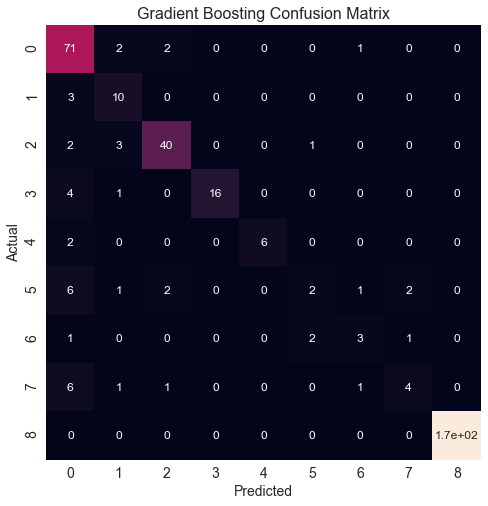

[[ 71   2   2   0   0   0   1   0   0]
 [  3  10   0   0   0   0   0   0   0]
 [  2   3  40   0   0   1   0   0   0]
 [  4   1   0  16   0   0   0   0   0]
 [  2   0   0   0   6   0   0   0   0]
 [  6   1   2   0   0   2   1   2   0]
 [  1   0   0   0   0   2   3   1   0]
 [  6   1   1   0   0   0   1   4   0]
 [  0   0   0   0   0   0   0   0 166]]


In [2599]:
# Plot Confusion Matrix.
plot_confusion_matrix(testY, GB_Ctypes_predict_test, title="Gradient Boosting Confusion Matrix", size=(8, 8))

In [2600]:
# Cross validate the model with 10 folds on accuracy.
crossV_score = cross_validate(GB_Ctypes_best, X, Y, cv=10, scoring="accuracy", n_jobs=3)
print("Mean Cross Validation Accuracy: {}".format(np.mean(crossV_score["test_score"])))

Mean Cross Validation Accuracy: 0.8019563295342195


In [2601]:
# Plot some statistics on the best performing model
GB_stats = cancer_type_stats(testY, GB_Ctypes_predict_test)
GB_stats

Specificity: 1.0
Sensitivities:


,Colorectum,Lung,Breast,Pancreas,Ovary,Esophagus,Liver,Stomach,Healthy
0,0.934211,0.769231,0.869565,0.761905,0.75,0.142857,0.428571,0.307692,1.0


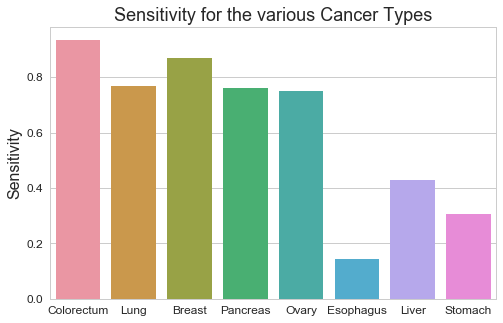

In [2613]:
# Display the resulting Sensitivities
plt.figure(figsize=(8,5))
sns.barplot(data=GB_stats.iloc[:,:-1])
plt.title('Sensitivity for the various Cancer Types', size=18)
plt.xticks(size=12)
plt.yticks(size=12)
plt.ylabel("Sensitivity", size=16);

In [2603]:
# Display the count of each cancer type in the dataset
cancer_count()

,Colorectum,Lung,Breast,Pancreas,Ovary,Esophagus,Liver,Stomach,Healthy
Cancer Count,388,104,209,93,54,45,44,68,812


## Conclusions

First **we successfully managed to identify every single cancer patient** in our data. Both *Specificity* and *Sensitivity* were calculated to a perfect 1.0; meaning that none of the healthy patients were classified as having cancer, nor was any of the cancer patients classified as healthy. The subsequent AUC score was an equally perfect 1.0. That's really good! On top of that, we indentified the protein *AFP (pg/ml)* as being the most important in making these predictions. In fact, our Gradient Boosting model was able to make perfect predictions solely on this protein. 

We suspected that the AFP (pg/ml) protein was too well correlated with the output variable and made predictions using a Random Forest model as well. This model attributed an importance of around 49 percent to this protein, allowing us to abandon the idea of discarding the AFP (pg/ml) protein from the input feature set. (This is a slightly alternative, amature's, approach to reaching this conclusion, but which is later validated with [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4795737/) about biomarkers.) More work should be done on a larger scale with thousands, or even tens of thousands, of cancer patients to validate this, but the results are nevertheless promising. 

Making predictions for each **Cancer Type** was more cumbersome. We still managed to achieve a perfect Specificity of 1.0 by classifying all healthy patients as healthy. Sensitivity was more tricky, ranging between 0.14 and 0.93 for the eight cancer types **with a median of 0.75. Considering the top five cancer Sensitivities, as they did in the published paper, range varied between 0.75 and 0.93 (Colorectum, Breast, Lung, Pancreas and Ovary). It's in line with, or slightly higher**, than the range of  0.69 to 0.98 and median of 0.70 achieved in the paper. 

What is surprising though is the types of cancer that experienced the highest scorings. In the published paper Ovary, Liver, Stomach, Pancreas, and Esophagus cancer reached highest specificities while we scored highest on Colorectum, Breast, Lung, Pancreas and Ovary. Only Ovary and Pancreas overlap. In general for Machine Learning, more data mean better results. It makes therefore sense that we achieve the highest specificities where there are more cancer type samples to train our model on (i.e. Colorectum, Breast, Lung and Pancreas). See above printout. The published paper's results are completely opposite on this point. 

We can conclude that the project has been a success by reaching, and in some sense also beating, the scores achieved in the research paper. There are still several things I would like to try out such as fine tune the model even more, adding the mutations we discarded in the beginning as input feature; it might also be worth to train a model for each one of the eight cancer types. Another approach might be to train a Deep Learning model on the data using Keras/Tensorflow (rather than doing it in sklearn since we would be able to tune it better). Lastly, the models would likely benefit from more data and it should thus be a priority if production at scale is a long term objective. 